# Imports

In [1]:
# System
import sys
import os
# Time
import time
# Date time
import datetime as dt
# PyTorch framework
import torch
from torch import nn
# Work with arrays
import numpy as np
# Work with dataframes
import pandas as pd
# Make figures
import matplotlib.pyplot as plt
import seaborn as sns
# # Hyperparameters optimization
# import optuna

# Amplitude functions

## Gaussian

In [2]:
class Gaussian(nn.Module):
  """Custom Gaussian amplitude function class"""

  def __init__(self, config):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.device = config['device']

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    forward = torch.mul(
      forward.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
    ).t()
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      temporalTerm = torch.ones(
        (
          len(x),
          self.numberOfStates
        ),
        device=self.device
      )
      temporalTerm = torch.mul(
        temporalTerm.t(),
        torch.exp(-torch.sum(x**2, axis=1) / 2) * (-2 * x[:, coordinateNumber] / 2),
      ).t()
      gradient[:, coordinateNumber, :] = temporalTerm
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    laplacian = torch.mul(
      laplacian.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
      * (
        torch.sum((-2 * x / 2) ** 2, axis=1)
        - 2 * torch.sum(torch.ones_like(x) / 2, axis=1)
      )
    ).t()
    return laplacian


# Neural network

In [3]:
class NeuralNetwork(nn.Module):
  """Class for a neural network"""

  def __init__(self, config):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.hiddenLayerSize = config['hidden layer size']
    self.device = config['device']
    self.defActivationFunction(config)
    self.numberOfHiddenLayers = config['number of hidden layers']
    self.defAndInitStack()
    self.stack.to(self.device)

  def defActivationFunction(self, config):
    if config['activation function'] == 'sin':
      self.activationFunction = CustomSin()
    elif config['activation function'] == 'tanh':
      self.activationFunction = CustomTanh()
    else:
      print("INVALID ACTIVATION FUNCTION NAME")
      sys.exit(1)

  def defAndInitStack(self):
    self.stack = nn.Sequential()
    self.stack.append(
      nn.Linear(
        self.coordinateSpaceDim,
        self.hiddenLayerSize
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for hiddenLayerNumber in range(self.numberOfHiddenLayers-1):
      self.stack.append(
        nn.Linear(
          self.hiddenLayerSize,
          self.hiddenLayerSize
        )
      )
      self.stack.append(
        self.activationFunction
      )
    self.stack.append(
      nn.Linear(
        self.hiddenLayerSize,
        self.numberOfStates
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for stackSliceNumber in range(len(self.stack)):
      if "weight" in dir(self.stack[stackSliceNumber]):
        nn.init.normal_(
          self.stack[stackSliceNumber].weight,
          0,
          np.sqrt(0.1)
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.stack(x)

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.coordinateSpaceDim,
          self.numberOfStates
        ),
        device = self.device
      )
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      function = self.stack[0*2+1](self.stack[0*2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      gradient[:, coordinateNumber, :] = firstDerivative
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    preresult = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      secondDerivative = self.activationFunction.secondDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber] ** 2
      function = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        secondDerivative = self.activationFunction.secondDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        ) ** 2 \
        + self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
            secondDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      preresult[:, coordinateNumber, :] = secondDerivative
    return torch.sum(preresult, axis=1)

class CustomSin(nn.Module):
    """Custom sin activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -torch.sin(x)

class CustomTanh(nn.Module):
    """Custom tanh activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return 1 / torch.cosh(x) ** 2

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -2 * torch.sinh(x) / torch.cosh(x) ** 3

# Trial function

In [4]:
class TrialFunction(nn.Module):
  """Trial function class"""

  def __init__(self, config, name: str):
    """Initialize trial function"""
    super().__init__()
    self.name = name
    self.PATH = "../models/" + self.name + ".pt"
    self.defDevice(config)
    self.neuralNetwork = NeuralNetwork(config)
    self.defAmplitudeFunction(config)

  def defDevice(self, config):
    """Define device"""
    self.device = config['device']

  def defAmplitudeFunction(self, config):
    """Define amplitude function"""
    if config['amplitude function'] == 'gaussian':
      self.amplitudeFunction = Gaussian(config)
    else:
      print("INVALID AMPLITUDE FUNCTION NAME")
      sys.exit(1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = self.neuralNetwork(x) * self.amplitudeFunction(x)
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.neuralNetwork.coordinateSpaceDim,
          self.neuralNetwork.numberOfStates
        ),
        device = self.device
      )
    )
    theAmplitudeFunction = self.amplitudeFunction(x)
    theAmplitudeFunctionGradient = self.amplitudeFunction.gradient(x)
    theNeuralNetwork = self.neuralNetwork(x)
    theNeuralNetworkGradient = self.neuralNetwork.gradient(x)
    for coordinateNumber in range(self.neuralNetwork.coordinateSpaceDim):
      gradient[:, coordinateNumber, :] = (
        theNeuralNetworkGradient[:, coordinateNumber, :] * theAmplitudeFunction
        + theNeuralNetwork * theAmplitudeFunctionGradient[:, coordinateNumber, :]
      )
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = (
      self.neuralNetwork.laplacian(x) * self.amplitudeFunction(x)
      + self.neuralNetwork(x) * self.amplitudeFunction.laplacian(x)
      + 2 * torch.sum(
        self.neuralNetwork.gradient(x) * self.amplitudeFunction.gradient(x),
        axis=1
      )
    )
    return laplacian

  def weightFunction(self, x: torch.Tensor) -> torch.Tensor:
    weightFunction = torch.mean(self.forward(x)**2, axis=1)
    # weightFunction = torch.mean(self.forward(x)**2, axis=1)
    return weightFunction

  def norm(self, x: torch.Tensor) -> torch.Tensor:
    norm = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      norm[stateNumber] = torch.mean(
        forward[:, stateNumber]**2 / weightFunction
      )
    return norm

  def spectrum(self, x: torch.Tensor) -> torch.Tensor:
    spectrum = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x)
    potential = 0.5 * torch.sum(x*x, axis=1)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      spectrum[stateNumber] = torch.mean(
        forward[:, stateNumber] * (
          -0.5* laplacian[:, stateNumber]
          + potential * forward[:, stateNumber]
        ) / weightFunction
      )
    spectrum = spectrum / self.norm(x)
    return spectrum

  def totalSqueredResidual(self, x: torch.Tensor) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x)
    spectrum = self.spectrum(x)
    norm = self.norm(x)
    return sum(
      [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]
    )

  def totalNormalisationError(self, x: torch.Tensor) -> torch.Tensor:
    return torch.sum((self.norm(x) - torch.tensor(1, device=self.device)) ** 2)

  def totalOrthogonalisationError(self, x: torch.Tensor) -> torch.Tensor:
    orthogonError = torch.zeros(
      (
        self.neuralNetwork.numberOfStates,
        self.neuralNetwork.numberOfStates
      ),
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x)
    norm = self.norm(x)
    for stateNumber1 in range(1, self.neuralNetwork.numberOfStates):
      for stateNumber2 in range(0, stateNumber1):
        orthogonError[stateNumber1, stateNumber2] = (
          torch.square(
            torch.mean(
              forward[:, stateNumber1]
              * forward[:, stateNumber2]
              / weightFunction
            )
          )
          / norm[stateNumber1]
          / norm[stateNumber2]
        )
    return torch.sum(orthogonError)

# Metropolis sampler

In [5]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, config):
    self.epsilon = config['metropolis algorithm parameter']
    self.device = config['device']
    self.sample = self.initialSample(config)

  def initialSample(self, config) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          config['sample size'],
          config['coordinate space dimension']
        )
      ) - 0.5
    ).to(self.device)

  def updateSampleBasOnDistrDens(self, distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = distributionDensity(newSample) / distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

# Train NN-based multistate solver (NNBMS)

In [6]:
time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())

'04Oct2023_12:56:20'

In [7]:
def compute_losses_on_uniform_sample(trialFunction: TrialFunction, config):
    sampler = MetropolisSampler(config)
    lossFunction = nn.L1Loss()
    # Losses
    r = trialFunction.totalSqueredResidual(sampler.sample)
    a = trialFunction.totalNormalisationError(sampler.sample)
    b = trialFunction.totalOrthogonalisationError(sampler.sample)
    e = trialFunction.spectrum(sampler.sample)
    loss = lossFunction(
        config['residual term weight'] * r
        + config['normalisation term weight'] * a
        + config['orthogonalisation term weight'] * b
        + config['energy term weigth'] * torch.sum(e),
        torch.tensor(0.0).to(config['device']),
    )
    return r, a, b, e, loss

def build_and_train_trialFunction(config, trial):
    """Initalizes and trains trial function"""
    initialTime = time.time()
    timeHistory =  np.full(config['number of training steps'], np.nan)
    lossHistory = {
        'total loss' : np.full(config['number of training steps'], np.nan),
        'total squered residual' : np.full(config['number of training steps'], np.nan),
        'total normalisation error' : np.full(config['number of training steps'], np.nan),
        'total orthogonalisation error' : np.full(config['number of training steps'], np.nan)
    }
    eHistory = [None] * config['number of training steps']
    
    name = str(
        "3d_"+
        time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())
    )
    trialFunction = TrialFunction(config, name)

    optimizer = torch.optim.AdamW(
        params=list(trialFunction.parameters()),
        lr=config['initial learning rate'],
        weight_decay=config['weight decay'],
    )

    lossFunction = nn.L1Loss()
    
    for step in range(config['number of training steps']):
        if step == 0:
            sampler = MetropolisSampler(config)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(trialFunction.weightFunction)

        # Loss function
        r = trialFunction.totalSqueredResidual(sampler.sample)
        a = trialFunction.totalNormalisationError(sampler.sample)
        b = trialFunction.totalOrthogonalisationError(sampler.sample)
        e = trialFunction.spectrum(sampler.sample)
        loss = lossFunction(
            config['residual term weight'] * r
            + config['normalisation term weight'] * a
            + config['orthogonalisation term weight'] * b
            + config['energy term weigth'] * torch.sum(e),
            torch.tensor(0.0).to(config['device']),
        )

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save some history
        timeHistory[step] = time.time() - initialTime
        lossHistory['total loss'][step] = loss.item()
        lossHistory['total squered residual'][step] = r.cpu().detach().numpy()
        lossHistory['total normalisation error'][step] = a.cpu().detach().numpy()
        lossHistory['total orthogonalisation error'][step] = b.cpu().detach().numpy()
        eHistory[step] = e.cpu().detach().numpy()

        # Print current information
        # if step == 0:
        #     info = (
        #         "step,"
        #         + " time [s],"
        #         + " loss,"
        #         + " r,"
        #         + " a,"
        #         + " b,"
        #     )
        #     for i in range(len(e.cpu().detach().numpy())):
        #         info += f" E{i},"
        #     print(info[:-1])
        periodBetweenReports = 5000
        if step % periodBetweenReports == 0:
            r, a, b, e, loss = compute_losses_on_uniform_sample(
                trialFunction, 
                config
            )
            
            # info = (
            #     f"{step},"
            #     + f" {time.time() - initialTime:.2f},"
            #     + f" {loss.cpu().detach().numpy():.4e},"
            #     + f" {r.cpu().detach().numpy():.4e},"
            #     + f" {a.cpu().detach().numpy():.4e},"
            #     + f" {b.cpu().detach().numpy():.4e},"
            # )
            # for ee in e.cpu().detach().numpy():
            #     info += f" {ee:.2f},"
            # print(info[:-1])
            
            # Prune the training if it is needed
            trial.report(r.cpu().detach().numpy(), step / periodBetweenReports)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
    timeHistoryDF = pd.DataFrame(data={'time [s]' : timeHistory})
    lossHistoryDF = pd.DataFrame(data=lossHistory)
    eHistoryDF = pd.DataFrame(data=eHistory)
    timeHistoryDF.to_csv(f"../loss/time_{name}.csv")
    lossHistoryDF.to_csv(f"../loss/loss_{name}.csv")
    eHistoryDF.to_csv(f"../loss/e_{name}.csv")
    torch.save(trialFunction.state_dict(), trialFunction.PATH)
    return trialFunction

# Hyperparameters tuning with Optuna

In [8]:
def objective(trial):
    config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : trial.suggest_categorical("hidden layer size", [5,10,20,30,50,60,100]),
        "number of hidden layers" : trial.suggest_int("number of hidden layers", 1, 5),
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000
    }

    # print("hidden layer size", config["hidden layer size"])
    # print("number of hidden layers", config["number of hidden layers"])
    
    trialFunction = build_and_train_trialFunction(config, trial)

    r, a, b, e, loss = compute_losses_on_uniform_sample(
        trialFunction, 
        config
    )

    return r.cpu().detach().numpy()

In [9]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=50)

[I 2023-10-04 15:56:20,709] A new study created in memory with name: no-name-51bf42cb-5a78-4f6a-b2fb-d1f455e6098e
[I 2023-10-04 16:32:50,654] Trial 0 finished with value: 0.012318886816501617 and parameters: {'hidden layer size': 20, 'number of hidden layers': 4}. Best is trial 0 with value: 0.012318886816501617.
[I 2023-10-04 16:56:41,701] Trial 1 finished with value: 0.011884702369570732 and parameters: {'hidden layer size': 10, 'number of hidden layers': 2}. Best is trial 1 with value: 0.011884702369570732.
[I 2023-10-04 17:18:02,347] Trial 2 finished with value: 0.025597184896469116 and parameters: {'hidden layer size': 60, 'number of hidden layers': 1}. Best is trial 1 with value: 0.011884702369570732.
[I 2023-10-05 05:24:50,415] Trial 3 finished with value: 1.0563654899597168 and parameters: {'hidden layer size': 100, 'number of hidden layers': 5}. Best is trial 1 with value: 0.011884702369570732.
[I 2023-10-05 17:30:55,730] Trial 4 finished with value: 0.6709067821502686 and par

## Best trial

In [10]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

hidden layer size: 30
number of hidden layers: 1


## Tuning visualization

In [77]:
df = study.trials_dataframe()
df[df['state']=='COMPLETE']

,number,value,datetime_start,datetime_complete,duration,params_hidden layer size,params_number of hidden layers,state
0,0,0.012319,2023-10-04 15:56:20.709942,2023-10-04 16:32:50.654379,0 days 00:36:29.944437,20,4,COMPLETE
1,1,0.011885,2023-10-04 16:32:50.655359,2023-10-04 16:56:41.701538,0 days 00:23:51.046179,10,2,COMPLETE
2,2,0.025597,2023-10-04 16:56:41.702586,2023-10-04 17:18:02.347170,0 days 00:21:20.644584,60,1,COMPLETE
3,3,1.056365,2023-10-04 17:18:02.348199,2023-10-05 05:24:50.415117,0 days 12:06:48.066918,100,5,COMPLETE
4,4,0.670907,2023-10-05 05:24:50.416835,2023-10-05 17:30:55.729857,0 days 12:06:05.313022,100,5,COMPLETE
8,8,0.022351,2023-10-05 17:37:53.817662,2023-10-05 17:55:52.659624,0 days 00:17:58.841962,5,1,COMPLETE
9,9,0.007574,2023-10-05 17:55:52.660686,2023-10-05 18:17:09.222721,0 days 00:21:16.562035,30,1,COMPLETE
11,11,0.020380,2023-10-05 18:17:09.392906,2023-10-05 18:40:09.311948,0 days 00:22:59.919042,10,2,COMPLETE
13,13,0.013287,2023-10-05 18:40:10.646556,2023-10-05 19:03:12.225326,0 days 00:23:01.578770,10,2,COMPLETE
15,15,0.011853,2023-10-05 19:03:12.393317,2023-10-05 19:24:40.604370,0 days 00:21:28.211053,30,1,COMPLETE


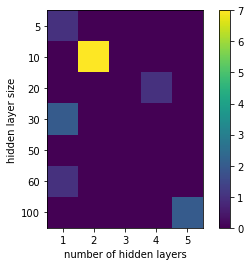

In [60]:
hiddenLayerSizes = [5,10,20,30,50,60,100]
numbersOfHiddenLayers = [1,2,3,4,5]

numberOfCompilations = np.zeros((7,5))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        numberOfCompilations[i,j] = len(
            df[
            (df['state']=='COMPLETE')
            *(df['params_hidden layer size']==hiddenLayerSize)
            *(df['params_number of hidden layers']==numberOfHiddenLayers)
            ]
        )
pcol = plt.imshow(numberOfCompilations)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(pcol)

/tmp/ipykernel_561/2210500643.py:10: RuntimeWarning: Mean of empty slice.
  ]['value'].to_numpy().mean()


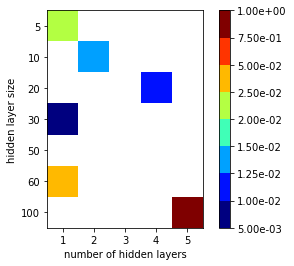

In [68]:
from matplotlib import colors

finalResults = np.zeros((7,5))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults[i,j] = df[
            (df['state']=='COMPLETE')
            *(df['params_hidden layer size']==hiddenLayerSize)
            *(df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().mean()
bounds = [0.005,0.01,0.0125,0.015,0.02,0.025,0.05,0.75,1]
im = plt.imshow(
    finalResults,
    cmap='jet',
    norm=colors.BoundaryNorm(boundaries=bounds, ncolors=256)
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im, ticks=bounds)
cbar.set_ticklabels([f"{b:.2e}" for b in bounds])

/usr/lib/python3/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/lib/python3/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


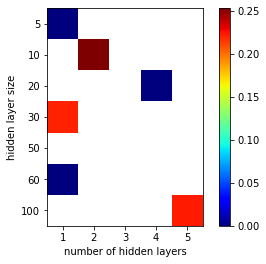

In [133]:
from matplotlib import colors

finalResults_std = np.zeros((7,5))
for i, hiddenLayerSize in enumerate(hiddenLayerSizes):
    for j, numberOfHiddenLayers in enumerate(numbersOfHiddenLayers):
        finalResults_std[i,j] = df[
            (df['state']=='COMPLETE')
            *(df['params_hidden layer size']==hiddenLayerSize)
            *(df['params_number of hidden layers']==numberOfHiddenLayers)
            ]['value'].to_numpy().std() / finalResults[i,j]
im = plt.imshow(
    finalResults_std,
    cmap='jet'
)
plt.yticks(np.arange(len(hiddenLayerSizes)), labels=hiddenLayerSizes)
plt.ylabel('hidden layer size')
plt.xticks(np.arange(len(numbersOfHiddenLayers)), labels=numbersOfHiddenLayers)
plt.xlabel('number of hidden layers')
cbar = plt.colorbar(im)

In [124]:
(df[(df['state']=='COMPLETE')*(df['params_hidden layer size']==10)*(df['params_number of hidden layers']==2)])

,number,value,datetime_start,datetime_complete,duration,params_hidden layer size,params_number of hidden layers,state
1,1,0.011885,2023-10-04 16:32:50.655359,2023-10-04 16:56:41.701538,0 days 00:23:51.046179,10,2,COMPLETE
11,11,0.020380,2023-10-05 18:17:09.392906,2023-10-05 18:40:09.311948,0 days 00:22:59.919042,10,2,COMPLETE
13,13,0.013287,2023-10-05 18:40:10.646556,2023-10-05 19:03:12.225326,0 days 00:23:01.578770,10,2,COMPLETE
21,21,0.019602,2023-10-05 19:59:18.295999,2023-10-05 20:22:23.931300,0 days 00:23:05.635301,10,2,COMPLETE
26,26,0.009663,2023-10-05 20:36:01.323068,2023-10-05 20:58:55.596796,0 days 00:22:54.273728,10,2,COMPLETE
31,31,0.015692,2023-10-05 21:04:58.204667,2023-10-05 21:27:23.025587,0 days 00:22:24.820920,10,2,COMPLETE
40,40,0.012574,2023-10-05 21:36:29.911014,2023-10-05 21:59:57.494385,0 days 00:23:27.583371,10,2,COMPLETE


In [126]:
name = "04Oct2023_13:32:50"

trialFunction_3D = TrialFunction(
    {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 10,
        "number of hidden layers" : 2,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000
    },
    "3d_"+name
)
trialFunction_3D.load_state_dict(torch.load(trialFunction_3D.PATH))
trialFunction_3D.eval()

TrialFunction(
  (neuralNetwork): NeuralNetwork(
    (activationFunction): CustomSin()
    (stack): Sequential(
      (0): Linear(in_features=3, out_features=10, bias=True)
      (1): CustomSin()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): CustomSin()
      (4): Linear(in_features=10, out_features=5, bias=True)
      (5): CustomSin()
    )
  )
  (amplitudeFunction): Gaussian()
)

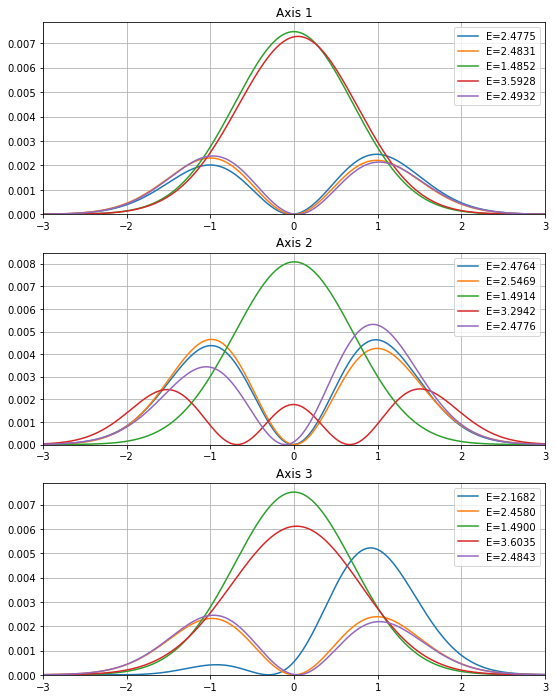

In [127]:
fig, axes = plt.subplots(
    3,1,
    figsize=(9*1,12),
    squeeze=False
)

for axNumber, ax in enumerate(axes[:,0]):
    grid = torch.zeros(
        (1000,3),
        device="cuda"
    )
    grid[:,axNumber] = torch.linspace(-3,3,1000,device="cuda")
    for i in range(5):
        ax.plot(
            grid[:,axNumber].cpu().detach().numpy(), 
            (
                trialFunction_3D(grid)[:,i].cpu().detach().numpy()**2
                / trialFunction_3D.norm(grid)[i].cpu().detach().numpy()
            ),
            label=f'E={trialFunction_3D.spectrum(grid)[i]:.4f}'
        )
    ax.set_title(f"Axis {axNumber+1}")
    ax.legend()
    ax.set_xlim(-3,3)
    ax.set_ylim(0,None)
    ax.grid()

In [128]:
timeHistory_1 = pd.read_csv("../loss/time_3d_"+name+".csv")
lossHistory_1 = pd.read_csv("../loss/loss_3d_"+name+".csv")
eHistory_1 = pd.read_csv("../loss/e_3d_"+name+".csv")

Text(0.5, 0, 'Iteration number')

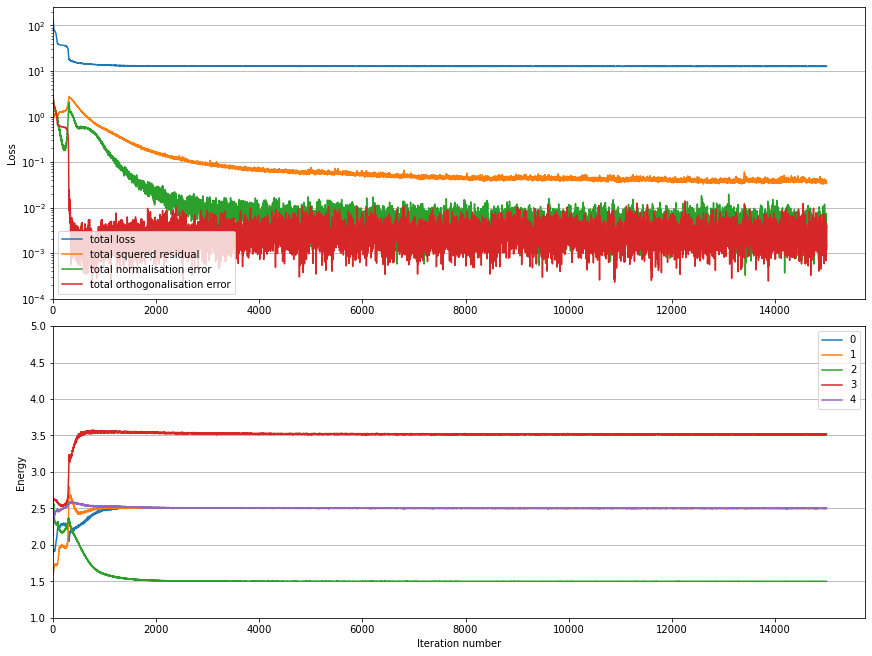

In [129]:
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(12,9), layout='constrained')
lossHistory_1[[
    'total loss', 
    'total squered residual', 
    'total normalisation error',
    'total orthogonalisation error'
]].plot(ax=ax)
ax.set_yscale('log')
ax.grid(axis='y')
ax.set_ylim(1e-4,None)
ax.set_xlim(0,None)
ax.set_ylabel('Loss')
# plt.xlabel('Iteration number')

eHistory_1[[
    '0', 
    '1', 
    '2',
    '3',
    '4'
]].plot(ax=ax1)
# ax.set_yscale('log')
ax1.grid(axis='y')
ax1.set_ylim(1,5)
ax1.set_xlim(0,None)
ax1.set_ylabel('Energy')
ax1.set_xlabel('Iteration number')